In [31]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import product
from par_funcs import *
%matplotlib inline
sys.path.append('..')
cmap = matplotlib.colors.ListedColormap(np.vstack( ((0, 0, 0), np.random.rand(1e6, 3))) )
V = 20

# -------------------------------- parameters ---------------------------------------
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
# pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'
out_folder = '/nobackup/turaga/singhc/misc/' # _3k _vol has full, max_len = 300
outname = out_folder+'out.h5'
NUM_WORKERS = 32
MAX_LEN = 300

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
pred_file_rand = '/nobackup/turaga/singhc/rand_affs/small.h5'
np.random.seed(seed=703858704)
affs = np.random.rand(3,200,3072,3072).astype('float32')
if op.isfile(pred_file_rand):
    os.remove(pred_file_rand)
f = h5py.File(pred_file_rand, 'a')
f['main'] = affs
f.close()
pred_file = pred_file_rand

# Partition

In [33]:
t1 = time.time()
partition_data = partition_subvols(pred_file,out_folder,max_len=MAX_LEN)
print "time",time.time()-t1,"secs"

dims [100 100 100]
num_vols [1 1 1]
deltas [100 100 100]
time 0.00662803649902 secs


# Call Watershed

In [34]:
t1 = time.time()
x = eval_with_par_map(partition_data[0][0:1],NUM_WORKERS)
print "time",time.time()-t1,"secs"

finished /nobackup/turaga/singhc/misc/0_0_0_vol/ watershed
time 2.20897197723 secs


# Stitch

i,x,y,z 0 0 0 0


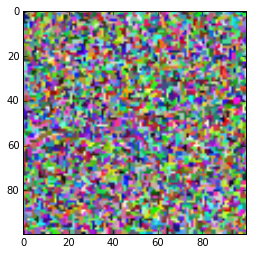

filter_merges...


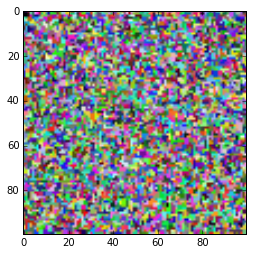

merge


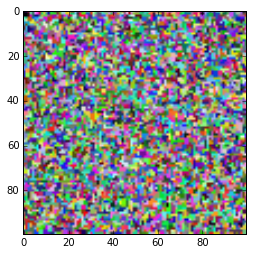

calculating seg_sizes...


In [38]:
def stitch_and_save(partition_data,outname):
    args,starts,ends,dims,num_vols = partition_data
#     (X,Y,Z) = num_vols #(1,1,2) # num_vols
    X,Y,Z = 1,1,1
    if not outname.endswith('.h5'):
        outname += '.h5'
    if op.isfile(outname):
        os.remove(outname)
    f = h5py.File(outname, 'a')
    dset_seg = f.create_dataset('seg', dims, dtype='uint64', chunks=True)
#     dset_seg = f.create_dataset('seg', (110,220,220), dtype='uint64', chunks=True)
    inc,re,merges,rgs,i_arr=0,{},{},{},[]

    # calc all merges, set dset_seg, rg with incrementing
    for x,y,z in product(range(X),range(Y),range(Z)):
        i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
        i_arr.append(i)
        s,e = starts[i],ends[i]
        basic_file = h5py.File(args[i][-1]+'basic.h5','r')
        seg,rg = np.array(basic_file['seg']),np.array(basic_file['rg'])
        seg[seg!=0]+=inc
        rg[:,:2] += inc
        rgs[i] = rg
        inc = np.max(seg)
        print "i,x,y,z",i,x,y,z
        if not z==0: 
            re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]:e[1],s[2]+3],edge_maxes=seg[:,:,3], re=re, merges=merges)
        if not y==0:
            re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]+3,s[2]:e[2]],edge_maxes=seg[:,3,:],re=re,merges=merges)
        if not x==0:
            re,merges = calc_merges(edge_mins=dset_seg[s[0]+3,s[1]:e[1],s[2]:e[2]],edge_maxes=seg[3,:,:],re=re, merges=merges)
        dset_seg[s[0]:e[0],s[1]:e[1],s[2]:e[2]] = seg[:,:,:]
        plt.imshow(dset_seg[0, :, :], cmap=cmap)
        plt.show()
    
    merges_filtered = filter_merges(merges)
    plt.imshow(dset_seg[V, :, :], cmap=cmap)
    plt.show()
    
    rgs = merge(merges_filtered,rgs,i_arr,args,f,max_val=inc)
    
    plt.imshow(dset_seg[V, :, :], cmap=cmap)
    plt.show()
    
    seg_sizes = calc_seg_sizes(f)

    # save
    f = h5py.File(outname, 'a')
    dset_seg_sizes = f.create_dataset('seg_sizes', data=np.array(seg_sizes))
    for key in rgs:
        rg_dset = f.create_dataset('rg_'+str(key),data=np.array(rgs[key]))
    dset_starts = f.create_dataset('starts',data=np.array(starts))
    dset_ends = f.create_dataset('ends',data=np.array(ends))                               
    f.close()
stitch_and_save(partition_data,outname)

# Agglomeration

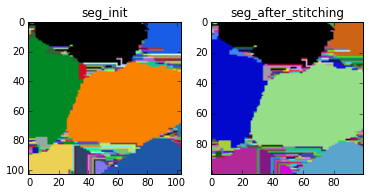

num_segs 22857 20775
rg lens 113550 112439


'\nseg_init_merged = merge_by_thresh(seg_init,seg_sizes_init,rg_init,thresh)\nseg_merged = merge_by_thresh(seg,seg_sizes,rg,thresh)\n\nplt.subplot(1,2,1)\nplt.imshow(seg_init_merged[V,:,:], cmap=cmap)\nplt.title(\'merged init\')\nplt.subplot(1,2,2)\nplt.imshow(seg_merged[V,:,:], cmap=cmap)\nplt.title(\'merged\')\nplt.show()\n\nprint "num_segs",len(np.unique(seg_init)),len(np.unique(seg))\nprint "rg lens",len(rg_init),len(rg)\n'

In [404]:
num,thresh = 0,2000

plt.subplot(1,2,1)
basic_file = h5py.File('/nobackup/turaga/singhc/par_zwshed/0_0_0_vol/'+'basic.h5','r')
seg_init = np.array(basic_file['seg'])
rg_init = np.array(basic_file['rg'])
keeps = rg_init[:,0]<rg_init[:,1]
rg_init = rg_init[keeps,:]

seg_sizes_init = np.array(basic_file['counts'])
basic_file.close()
plt.imshow(seg_init[V,:,:], cmap=cmap)
plt.title('seg_init')


plt.subplot(1,2,2)
f = h5py.File(outname, 'a')
s,e = f['starts'][num],f['ends'][num]
seg = f['seg'][s[0]:e[0]-3,s[1]:e[1]-3,s[2]:e[2]-3]
seg_sizes = np.array(f['seg_sizes'])
rg = np.array(f['rg_'+str(num)])
f.close()
plt.imshow(seg[V,:,:], cmap=cmap)
plt.title('seg_after_stitching')
plt.show()

print "num_segs",len(np.unique(seg_init)),len(np.unique(seg))
print "rg lens",len(rg_init),len(rg)

'''
seg_init_merged = merge_by_thresh(seg_init,seg_sizes_init,rg_init,thresh)
seg_merged = merge_by_thresh(seg,seg_sizes,rg,thresh)

plt.subplot(1,2,1)
plt.imshow(seg_init_merged[V,:,:], cmap=cmap)
plt.title('merged init')
plt.subplot(1,2,2)
plt.imshow(seg_merged[V,:,:], cmap=cmap)
plt.title('merged')
plt.show()

print "num_segs",len(np.unique(seg_init)),len(np.unique(seg))
print "rg lens",len(rg_init),len(rg)
'''

# Visualize

In [405]:
import nyroglancer
v = nyroglancer.Viewer()
v.set_hostname("localhost:8888")
v.put(seg, resolution=[40,4,4], vtype="seg", name="seg1")
v.put(seg_init, resolution=[40,4,4], vtype="seg", name="seg_init")
v.set_large() # this will widen the IPython column to show a large viewer
v.show()